In [1]:
import sys
sys.path.append('../..')

In [2]:
device='cpu'

In [3]:
import torch
import matplotlib.pyplot as plt
from data_utils import load_mnist_dataset, prepare_data
from hippocampal_sensory_layers import (
    HippocampalSensoryLayer,
    ComplexExactPseudoInverseHippocampalSensoryLayer,
    ComplexIterativeBidirectionalPseudoInverseHippocampalSensoryLayer,
    ComplexExactPseudoInverseHippocampalSensoryLayerComplexScalars,
    ComplexIterativeBidirectionalPseudoInverseHippocampalSensoryLayerComplexScalars,
    RegularizedComplexExactPseudoInverseHippocampalSensoryLayerComplexScalars
)
from tqdm import tqdm
from data_utils import load_mnist_dataset
from matplotlib.axes import Axes
from fourier_scaffold import FourierScaffold

In [4]:
def test_layer(
    layer: HippocampalSensoryLayer,
    hbook: torch.Tensor,
    sbook: torch.Tensor,
    large: bool,
):
    err_l1_first_img_s_h_s = -torch.ones(len(sbook))
    err_l1_last_img_s_h_s = -torch.ones(len(sbook))
    avg_accumulated_err_l2 = -torch.ones(len(sbook))
    first_img = sbook[0]

    for i in tqdm(range(len(sbook))):
        h_ = hbook[i]
        if large:
            h = torch.einsum("i,j->ij", h_, h_.conj()).flatten()
        else:
            h = h_

        s = sbook[i]
        layer.learn(h, s)

        err_l1_first_img_s_h_s[i] = torch.mean(
            torch.abs(
                layer.sensory_from_hippocampal(
                    layer.hippocampal_from_sensory(first_img)
                )[0]
                - first_img
            )
        )

        err_l1_last_img_s_h_s[i] = torch.mean(
            torch.abs(
                layer.sensory_from_hippocampal(
                    layer.hippocampal_from_sensory(sbook[i])
                )[0]
                - sbook[i]
            )
        )

        avg_accumulated_err_l2[i] = torch.mean(
            (
                layer.sensory_from_hippocampal(
                    layer.hippocampal_from_sensory(sbook[: i + 1])
                )
                - sbook[: i + 1]
            )
            ** 2
        )
        if (
            # err_l1_first_img_s_h_s[i] > 10e5
            # or avg_accumulated_err_l2[i] > 10e5
            torch.any(torch.isnan(err_l1_first_img_s_h_s[i]))
            or torch.any(torch.isnan(avg_accumulated_err_l2[i]))
        ):
            break

    return err_l1_first_img_s_h_s, err_l1_last_img_s_h_s, avg_accumulated_err_l2


def plot_avg_acc_l2_err_on_ax(ax: Axes, avg_accumulated_err_l2: torch.Tensor, label):
    x = torch.arange(0, len(avg_accumulated_err_l2[0]))
    mean = avg_accumulated_err_l2.mean(dim=0)
    std = avg_accumulated_err_l2.std(dim=0)
    ax.plot(x, mean, label=label)
    ax.fill_between(x, mean - std, mean + std, alpha=0.2)

    return ax


def plot_first_img_l1_err_on_ax(ax: Axes, err_l1_first_img_s_h_s: torch.Tensor, label):
    x = torch.arange(0, len(err_l1_first_img_s_h_s[0]))
    mean = err_l1_first_img_s_h_s.mean(dim=0)
    std = err_l1_first_img_s_h_s.std(dim=0)
    ax.plot(x, mean, label=label)
    ax.fill_between(x, mean - std, mean + std, alpha=0.2)

    return ax


def plot_last_img_l1_err_on_ax(ax: Axes, err_l1_last_img_s_h_s: torch.Tensor, label):
    x = torch.arange(0, len(err_l1_last_img_s_h_s[0]))
    mean = err_l1_last_img_s_h_s.mean(dim=0)
    std = err_l1_last_img_s_h_s.std(dim=0)
    ax.plot(x, mean, label=label)
    ax.fill_between(x, mean - std, mean + std, alpha=0.2)

    return ax


def set_ax_titles(ax: Axes, title, xtitle, ytitle):
    ax.set_title(title)
    ax.set_xlabel(xtitle)
    ax.set_ylabel(ytitle)
    ax.legend()


def add_vertical_bar_on_ax(ax: Axes, x):
    ax.axvline(x=x, color="b", linestyle="--")


def add_horizontal_bar_on_ax(ax: Axes, y, label):
    ax.axhline(y=y, color="k", linestyle="--", label=label)

Analytic vs. Iterative pseudoinverse

In [6]:
dataset = load_mnist_dataset()
N_patts = 100
N_s = 784
# data = torch.randn(N_patts, N_s)
data, noisy_data = prepare_data(dataset, N_patts, noise_level="none", device=device)
# data = torch.complex(data, torch.zeros_like(data))
runs = 1

N_h = 100
shapes = [(3, 3, 3), (5, 5, 5)]

/home/ezrahuang/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [ ]:
names = [
    "analytic",
    "analytic_complex",
    "analytic_complex_regularized",
    # "iterative",
    # "iterative_complex",
    # "iterative_no_sigmoid",
    # "iterative_no_sigmoid_complex_scalars",
]
err_l1_first_img_s_h_s = -torch.ones(len(names), runs, N_patts)
err_l1_last_img_s_h_s = -torch.ones(len(names), runs, N_patts)
avg_accumulated_err_l2 = -torch.ones(len(names), runs, N_patts)

scaffold = FourierScaffold(shapes=torch.tensor(shapes), D=N_h, _skip_K_calc=True)
gbook = scaffold.gbook().T[:N_patts]

large=False
N_h_layer = N_h**2 if large else N_h
if large:
    gbook_large = torch.einsum('bi,bj->bij', gbook, gbook.conj()).flatten(1)

for i, name in enumerate(names):
    for run in range(runs):
        if name == "analytic":
            layer = ComplexExactPseudoInverseHippocampalSensoryLayer(
                N_s, N_h_layer, N_patts, gbook_large if large else gbook, device=device
            )
        elif name == "analytic_complex":
            layer = ComplexExactPseudoInverseHippocampalSensoryLayerComplexScalars(
                N_s, N_h_layer, N_patts, gbook_large if large else gbook, device=device
            )
        elif name == 'analytic_complex_regularized':
            layer = RegularizedComplexExactPseudoInverseHippocampalSensoryLayerComplexScalars(
                N_s, N_h_layer, N_patts, gbook_large if large else gbook, device=device
            )
        elif name == "iterative":
            layer = ComplexIterativeBidirectionalPseudoInverseHippocampalSensoryLayer(
                N_s, N_h_layer, 1, True, 0.1, 0.1, device=device
            )
        elif name == 'iterative_complex':
            layer = ComplexIterativeBidirectionalPseudoInverseHippocampalSensoryLayerComplexScalars(
                N_s, N_h_layer, 1, True, 0.1, 0.1, device=device
            )
        elif name == 'iterative_no_sigmoid':
            layer = ComplexIterativeBidirectionalPseudoInverseHippocampalSensoryLayer(
                N_s, N_h_layer, 0, True, 0.1, 0.1, device=device
            )
        elif name == 'iterative_no_sigmoid_complex_scalars':
            layer = ComplexIterativeBidirectionalPseudoInverseHippocampalSensoryLayerComplexScalars(
                N_s, N_h_layer, 0, True, 0.1, 0.1, device=device
            )
        (
            err_l1_first_img_s_h_s[i, run],
            err_l1_last_img_s_h_s[i, run],
            avg_accumulated_err_l2[i, run],
        ) = test_layer(layer, gbook, data, large)
        # data[torch.randperm(len(data))

In [ ]:
print(err_l1_first_img_s_h_s)
print(err_l1_last_img_s_h_s)
print(avg_accumulated_err_l2)

import pickle

data_pkl = {
    "err_l1_first_img_s_h_s": err_l1_first_img_s_h_s,
    "err_l1_last_img_s_h_s": err_l1_last_img_s_h_s,
    "avg_accumulated_err_l2": avg_accumulated_err_l2,
}

with open('results_reg.pkl', 'wb') as f:
  pickle.dump(data_pkl, f)

In [ ]:
mean_of_dataset = torch.mean(data, dim=0)
rand = torch.rand_like(data)
err_mean_l2 = torch.mean((mean_of_dataset - data) ** 2).cpu()
err_mean_l1 = torch.mean(torch.abs(mean_of_dataset - data[0])).cpu()

fig, axs = plt.subplots(figsize=(15, 9))

for i, name in enumerate(names):
    plot_avg_acc_l2_err_on_ax(axs, avg_accumulated_err_l2[i], label=name)
  
add_vertical_bar_on_ax(axs, N_h)
add_horizontal_bar_on_ax(axs, err_mean_l1, label='err using "mean of dataset" image')
set_ax_titles(
    axs,
    f"shapes={shapes}, N_h={N_h}",
    "Number of images learned",
    "Average L2 error over all patterns",
)
axs.set_ylim(0, 3)
fig.savefig("hipp_sens_result_analytic_vs_iterative_dataset_err")

fig, axs = plt.subplots(figsize=(15, 9))
for i, name in enumerate(names):
    plot_first_img_l1_err_on_ax(axs, err_l1_first_img_s_h_s[i], label=name)
    # label=f"iterative hidden_layer_factor={1}, stationary={True}, epsilon_W_sh={0.1}, epsilon_W_hs={0.1}",
    
add_vertical_bar_on_ax(axs, N_h)
add_horizontal_bar_on_ax(axs, err_mean_l1, label='err using "mean of dataset" image')
set_ax_titles(
    axs,
    f"shapes={shapes}, N_h={N_h}",
    "Number of images learned",
    "Error when recovering first pattern",
)
axs.set_ylim(0, 3)
fig.savefig("hipp_sens_result_analytic_vs_iterative_first_img_err")

fig, axs = plt.subplots(figsize=(15, 9))
for i, name in enumerate(names):
    plot_last_img_l1_err_on_ax(axs, err_l1_last_img_s_h_s[i], label=name)
    # label=f"iterative hidden_layer_factor={1}, stationary={True}, epsilon_W_sh={0.1}, epsilon_W_hs={0.1}",
    
add_vertical_bar_on_ax(axs, N_h)
add_horizontal_bar_on_ax(axs, err_mean_l1, label='err using "mean of dataset" image')
set_ax_titles(
    axs,
    f"shapes={shapes}, N_h={N_h}",
    "Number of images learned",
    "Error when recovering last pattern",
)
axs.set_ylim(0, 3)
fig.savefig("hipp_sens_result_analytic_vs_iterative_last_img_err")

In [8]:
shapes = [(3, 3, 3), (5, 5, 5)]
N_h = 600
N_patts = 600
scaffold = FourierScaffold(shapes=torch.tensor(shapes), D=N_h, _skip_K_calc=True)
gbook = scaffold.gbook().T[:N_patts]
# N_s=100
# data = torch.sign(
#     torch.randn(N_patts, N_s)
# )
N_s = 784
data, noisy_data = prepare_data(dataset, N_patts, noise_level="none", device=device)
# layer = ComplexIterativeBidirectionalPseudoInverseHippocampalSensoryLayer(
#     784, N_h, 1, True, 0.1, 0.1, device=device
# )
# layer = RegularizedComplexExactPseudoInverseHippocampalSensoryLayerComplexScalars(
#     N_s, N_h, N_patts, gbook
# )
layer = ComplexExactPseudoInverseHippocampalSensoryLayer(
    N_s, N_h, N_patts, gbook
)
# layer.hbook=torch.randn_like(layer.hbook)
# layer.sbook=torch.randn_like(layer.sbook)
# layer = ComplexExactPseudoInverseHippocampalSensoryLayer(N_s, N_h, N_patts, gbook)
# layer = ComplexIterativeBidirectionalPseudoInverseHippocampalSensoryLayer(
#     N_s, N_h, 1, True, 0.01, 0.01, device=device
# )

/home/ezrahuang/Projects/rl-research/vectorhash/experiments/hipp_sens_fourier/../../fourier_scaffold.py:397: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.shapes = torch.tensor(shapes).int()


module shapes:  tensor([[3, 3, 3],
        [5, 5, 5]])
N_g (D) :  600
M       :  2
d       :  3
N_patts :  3375


/home/ezrahuang/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [9]:
# for j in tqdm(range(10)):
#   layer.learn(gbook[j], data[j])
layer.learn_batch(data[:200], gbook[:200])

tensor(0.9995)
tensor(0.9995)
tensor(31.7053)
tensor(31.7053)


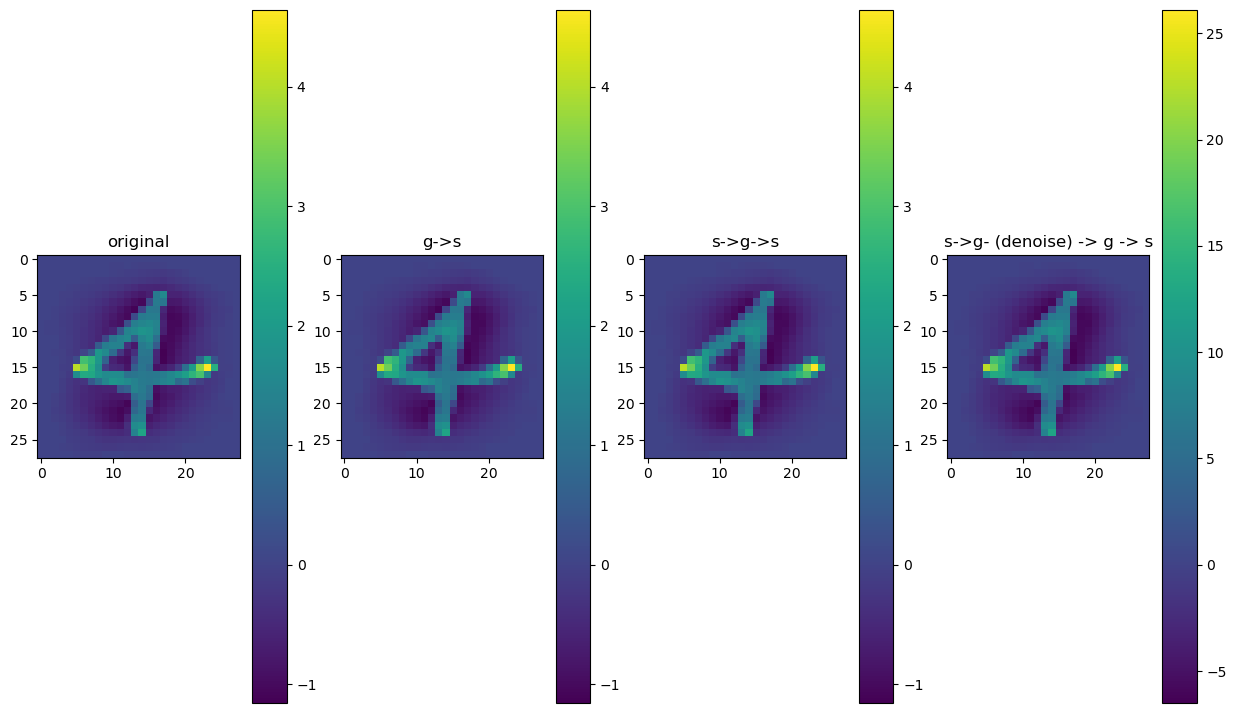

In [ ]:
from graph_utils import plot_imgs_side_by_side

j = 150
fig, axs = plt.subplots(ncols=4, figsize=(15, 9))
image_shape = (28, 28)


def denoise(g):
    P = g.H @ g
    print(P.norm())
    scaling = P.norm() ** 2
    sharpened_P = P @ P / scaling
    print(P.norm())
    return (sharpened_P @ scaffold.g_s).unsqueeze(0)


plot_imgs_side_by_side(
    imgs=[
        data[j].reshape(28, 28),
        layer.sensory_from_hippocampal(gbook[j]).reshape(28, 28),
        layer.sensory_from_hippocampal(
            layer.hippocampal_from_sensory(data[j])
        ).real.reshape(28, 28),
        layer.sensory_from_hippocampal(
            denoise(denoise(layer.hippocampal_from_sensory(data[j])))
        ).real.reshape(28, 28),
    ],
    axs=axs,
    titles=["original", "g->s", "s->g->s", "s->g- (denoise) -> g -> s"],
    fig=fig,
    use_first_img_scale=False,
)
# print((data[j] - layer.sensory_from_hippocampal(gbook[j])).abs().sum())
# print(
#     (data[j] - layer.sensory_from_hippocampal(layer.hippocampal_from_sensory(data[j])))
#     .abs()
#     .sum()
# )
# print(layer.W_hs.norm())
# print(layer.W_sh.norm())